# Regressão Logística I
## Tarefa II

Vamos trabalhar com a mesma base do exercício anterior, mas vamos aprofundar um pouco mais a nossa regressão.

In [144]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, roc_auc_score, roc_curve, auc

import statsmodels.formula.api as smf

In [145]:
url = 'https://archive.ics.uci.edu/ml/machine-learning-databases/heart-disease/processed.cleveland.data'

df = pd.read_csv(url, 
                 names=['age', 'sex', 'cp', 'trestbps', 'chol', 'fbs', 'restecg',
                        'thalach', 'exang', 'oldpeak', 'slope', 'ca', 'thal', 'num'])
df['flag_doente'] = (df['num']!=0).astype('int64')
df.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,num,flag_doente
0,63.0,1.0,1.0,145.0,233.0,1.0,2.0,150.0,0.0,2.3,3.0,0.0,6.0,0,0
1,67.0,1.0,4.0,160.0,286.0,0.0,2.0,108.0,1.0,1.5,2.0,3.0,3.0,2,1
2,67.0,1.0,4.0,120.0,229.0,0.0,2.0,129.0,1.0,2.6,2.0,2.0,7.0,1,1
3,37.0,1.0,3.0,130.0,250.0,0.0,0.0,187.0,0.0,3.5,3.0,0.0,3.0,0,0
4,41.0,0.0,2.0,130.0,204.0,0.0,2.0,172.0,0.0,1.4,1.0,0.0,3.0,0,0


A descrição das variáveis está recortada abaixo:
- age: idade do paciente em anos
- sex: sexo (1 = male; 0 = female)  
- cp: tipo de dor no peito
  - 1: angina típica
  - 2: angina atípica
  - 3: dor não-angina
  - 4: assintomático
- trestbps: pressão sanguínea em repouso (em mm Hg na admissão ao hospital)
- chol: colesterol sérico em mg/dl
- fbs: (açúcar no sangue em jejum > 120 mg/dl) (1 = True; 0 = False)
- restecg: resultados eletrocardiográficos em repouso
  - 0: normal
  - 1: tendo anormalidade da onda ST-T (Inversões de onda T e / ou ST com elevação ou depressão de > 0.05 mV)
  - 2: mostrando hipertrofia ventricular esquerda provável ou definitiva pelos critérios de Estes
- thalach: frequência cardíaca máxima alcançada
- exang: angina induzida por exercício(1 = sim; 0 = não)
- oldpeak = Depressão de ST induzida por exercício em relação ao repouso
- slope: Depressão de ST induzida por exercício em relação ao repouso
  - 1: inclinação ascendente
  - 2: estável
  - 3: inclinação descendente
- ca: número de vasos principais (0-3) coloridos por fluorosopia
- thal: 3 = normal; 6 = defeito corrigido; 7 = defeito reversível
- num: diagnóstico de doença cardíaga (status de doença angiográfica)

In [146]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 303 entries, 0 to 302
Data columns (total 15 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   age          303 non-null    float64
 1   sex          303 non-null    float64
 2   cp           303 non-null    float64
 3   trestbps     303 non-null    float64
 4   chol         303 non-null    float64
 5   fbs          303 non-null    float64
 6   restecg      303 non-null    float64
 7   thalach      303 non-null    float64
 8   exang        303 non-null    float64
 9   oldpeak      303 non-null    float64
 10  slope        303 non-null    float64
 11  ca           303 non-null    object 
 12  thal         303 non-null    object 
 13  num          303 non-null    int64  
 14  flag_doente  303 non-null    int64  
dtypes: float64(11), int64(2), object(2)
memory usage: 35.6+ KB


1. Considere o script que monta a análise bivariada que você fez na tarefa anterior. Transforme esse script em uma função, que deve:
- Ter como parâmetros de entrada:
    - Um *dataframe* contendo os dados a serem avaliados
    - Um *string* contendo o nome da variável resposta
    - Um *string* contendo o nome da variável explicativa
- E deve retornar um *dataframe* com os dados da bivariada. 
**Monte** a mesma bivariada pelo menos três variáveis qualitativas do *data-frame*. Qual delas parece discriminar mais o risco?

In [147]:
def bivariada_qualitativa(df, variavel_resposta, variaveis_explicativas):
    estatisticas_por_variavel = {}

    for variavel_explicativa in variaveis_explicativas:
        # Garantantindo que as variáveis explicativas sejam categóricas
        df[variavel_explicativa] = df[variavel_explicativa].astype('category')
        
        # Número de 'saudáveis' (variável resposta igual a 0) para cada categoria da variável explicativa
        num_saudaveis = df[df[variavel_resposta] == 0].groupby(variavel_explicativa).size()

        # Número de 'doentes' (variável resposta maior que 0) para cada categoria da variável explicativa
        num_doentes = df[df[variavel_resposta] > 0].groupby(variavel_explicativa).size()

        # Total de observações em cada categoria da variável explicativa
        total = df.groupby(variavel_explicativa).size()

        # Quantidade média de doentes (proporção de doentes) para cada categoria da variável explicativa
        media_doentes = num_doentes / total

        # Odds para cada categoria da variável explicativa
        odds = num_doentes / num_saudaveis

        # Odds ratio em relação à categoria de referência (primeira categoria)
        odds_referencia = odds / odds[odds.index[0]]

        # Logito (LOG(Odds)) para cada categoria da variável explicativa
        log_odds = odds.apply(lambda x: 0 if x == 0 else np.log(x))

        # Weight of Evidence (WOE) para cada categoria da variável explicativa
        woe = log_odds - log_odds[log_odds.index[0]]

        # Crie um DataFrame com as estatísticas
        estatisticas = pd.DataFrame({
            'Categoria da Variável Explicativa': num_saudaveis.index,
            'Número de Saudáveis': num_saudaveis.values,
            'Número de Doentes': num_doentes.values,
            'Total': total.values,
            'Quantidade Média de Doentes': media_doentes.values,
            'Odds': odds.values,
            'Odds Ratio (vs. Referência)': odds_referencia.values,
            'Logito (LOG(Odds))': log_odds.values,
            'Weight of Evidence (WOE)': woe.values
        })

        estatisticas_por_variavel[variavel_explicativa] = estatisticas

    return estatisticas_por_variavel

# Variáveis explicativas escolhidas
variaveis_explicativas = ['sex', 'cp', 'fbs', 'restecg']

# Estatísticas para cada uma das bivariadas
resultado_bivariada = bivariada_qualitativa(df, 'num', variaveis_explicativas)

# O resultado será o DataFrame correspondente.
for variavel, estatisticas in resultado_bivariada.items():
    print(f"Estatísticas para '{variavel}':")
    print(estatisticas)
    print("\n")


Estatísticas para 'sex':
  Categoria da Variável Explicativa  Número de Saudáveis  Número de Doentes  \
0                               0.0                   72                 25   
1                               1.0                   92                114   

   Total  Quantidade Média de Doentes      Odds  Odds Ratio (vs. Referência)  \
0     97                     0.257732  0.347222                     1.000000   
1    206                     0.553398  1.239130                     3.568696   

   Logito (LOG(Odds))  Weight of Evidence (WOE)  
0            -1.05779                    0.0000  
1             0.21441                    1.2722  


Estatísticas para 'cp':
  Categoria da Variável Explicativa  Número de Saudáveis  Número de Doentes  \
0                               1.0                   16                  7   
1                               2.0                   41                  9   
2                               3.0                   68                 18   
3   

2. Monte uma função semelhante para categorizar variáveis quantitativas contínuas (com muitas categorias) como ```age```.  
    Além dos mesmos parâmetros da função anterior, defina mais um parâmetro como número de categorias que você deseja quebrar. Defina um valor '*default*' de 5 grupos para este parâmetro.  

In [148]:
def bivariada_quantitativa(df, variavel_resposta, variavel_explicativa, num_categorias=5):
    # Calcula os limites dos intervalos para a categorização
    limites = np.linspace(df[variavel_explicativa].min(), df[variavel_explicativa].max(), num_categorias + 1)
    limites = np.round(limites, 2)  # Arredonda para evitar erros de precisão
    
    # Categoriza a variável explicativa
    df['explicativa_group'] = pd.cut(df[variavel_explicativa], bins=limites, include_lowest=True, labels=False)
    
    # Calcula as estatísticas
    num_observacoes_explicativa = df['explicativa_group'].value_counts().sort_index()
    num_saudaveis_explicativa = df[df[variavel_resposta] == 0]['explicativa_group'].value_counts().sort_index()
    num_doentes_explicativa = df[df[variavel_resposta] > 0]['explicativa_group'].value_counts().sort_index()
    total_explicativa = num_observacoes_explicativa.sum()
    proporcao_doentes_explicativa = num_doentes_explicativa / num_observacoes_explicativa
    odds_explicativa = num_doentes_explicativa / num_saudaveis_explicativa
    odds_esperado_explicativa = (num_doentes_explicativa.sum() / total_explicativa) / (num_saudaveis_explicativa.sum() / total_explicativa)
    odds_ratio_explicativa = odds_explicativa / odds_esperado_explicativa
    log_odds_explicativa = np.log(odds_explicativa)
    woe_explicativa = np.log(odds_explicativa / odds_esperado_explicativa)
    
    # Converta 'explicativa_group' de volta para o formato original para manter as categorias
    df['explicativa_group'] = pd.cut(df[variavel_explicativa], bins=limites, include_lowest=True)
    
    bivariada_explicativa = pd.DataFrame({
        'Num Observações': num_observacoes_explicativa,
        'Num Saudáveis': num_saudaveis_explicativa,
        'Num Doentes': num_doentes_explicativa,
        'Total': total_explicativa,
        'Proporção Doentes': proporcao_doentes_explicativa,
        'Odds': odds_explicativa,
        'Odds Ratio': odds_ratio_explicativa,
        'LOG(Odds)': log_odds_explicativa,
        'WOE': woe_explicativa
    }, index=range(num_categorias))
    
    return bivariada_explicativa

# Exemplo de uso:
# Suponha que você tenha um DataFrame 'df' com as colunas 'num' e 'age', onde 'num' é a variável resposta e 'age' é a variável explicativa.

# Especificação de número de categorias
num_categorias = 5
variavel_resposta = 'num'
variavel_explicativa = 'age'

# Calcular estatísticas para variável explicativa 'age'
bivariada_result = bivariada_quantitativa(df, variavel_resposta, variavel_explicativa, num_categorias)

# Imprimir as estatísticas
print(bivariada_result)

   Num Observações  Num Saudáveis  Num Doentes  Total  Proporção Doentes  \
0               11              8            3    303           0.272727   
1               71             50           21    303           0.295775   
2               97             56           41    303           0.422680   
3              107             40           67    303           0.626168   
4               17             10            7    303           0.411765   

       Odds  Odds Ratio  LOG(Odds)       WOE  
0  0.375000    0.442446  -0.980829 -0.815437  
1  0.420000    0.495540  -0.867501 -0.702108  
2  0.732143    0.863823  -0.311780 -0.146387  
3  1.675000    1.976259   0.515813  0.681206  
4  0.700000    0.825899  -0.356675 -0.191282  


3. Construa um modelo de regressão logística com as variáveis qualitativas: ```sex + cp +  trestbps``` e com a variável quantitativa ```age```.

**Interprete os parâmetros.**

In [149]:
# Selecionando as variáveis explicativas e a variável resposta
X = df[['sex', 'cp', 'trestbps', 'age']]
y = df['num']  # 'num' é a variável resposta

# Dividindo o conjunto de dados em treinamento e teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Criando o modelo de regressão logística
logistic_model = LogisticRegression(max_iter=10000)  # Aumentamos o número de iterações para garantir a convergência

# Treinando o modelo com os dados de treinamento
logistic_model.fit(X_train, y_train)

# Fazendo previsões com o modelo
y_pred = logistic_model.predict(X_test)

4. Avalie o seu modelo quanto a **calibragem**:
- Calcule a probabilidade de evento predita segundo o seu modelo
- Categorize essa probabilidade em G=5 grupos
- Calcule a probabilidade de evento predita média por grupo
- Calcule a taxa de eventos (média da variável indicadora de eventos) por grupo
- Compare graficamente o valor esperado versus observado para a taxa de maus por grupo

In [150]:
# Calculo da probabilidade de evento predita segundo o modelo para cada observação
probabilidades_preditas = logistic_model.predict_proba(X_test)[:, 1]

# Categorização das probabilidades em 5 grupos
categorias_probabilidade = pd.qcut(probabilidades_preditas, q=5, labels=False)

# Calculo da probabilidade média e a taxa de eventos por grupo
df_resultados = pd.DataFrame({
    'Probabilidade Predita': probabilidades_preditas,
    'Categoria de Probabilidade': categorias_probabilidade,
    'Variável Resposta (num)': y_test  # Variável de eventos
})

# Calcular a probabilidade média e a taxa de eventos por grupo
resultados_agrupados = df_resultados.groupby('Categoria de Probabilidade').agg({
    'Probabilidade Predita': 'mean',
    'Variável Resposta (num)': 'mean'
}).reset_index()

resultados_agrupados.columns = ['Categoria de Probabilidade', 'Probabilidade Média', 'Taxa de Eventos']

print(resultados_agrupados)

   Categoria de Probabilidade  Probabilidade Média  Taxa de Eventos
0                           0             0.083977         0.384615
1                           1             0.169052         1.083333
2                           2             0.210169         1.083333
3                           3             0.236104         1.500000
4                           4             0.267968         1.500000


c:\Users\rafa_\anaconda3\Lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


<Figure size 800x600 with 0 Axes>

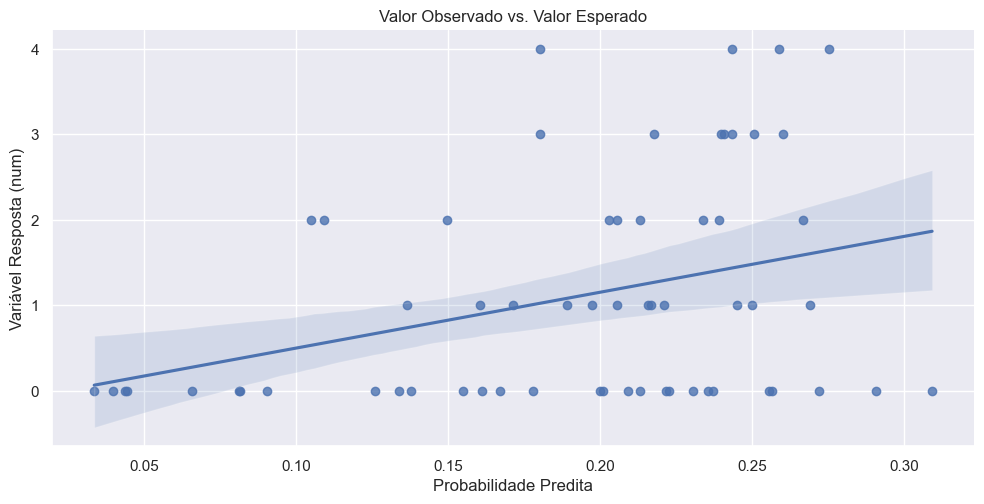

In [151]:
# Calculo da taxa de eventos observados por grupo
df_resultados = pd.DataFrame({
    'Probabilidade Predita': probabilidades_preditas,
    'Variável Resposta (num)': y_test  # Variável de eventos
})

# Calcular a taxa de eventos observados
taxa_eventos_obs = df_resultados.groupby('Probabilidade Predita')['Variável Resposta (num)'].mean().reset_index()

# 3. Criar o gráfico comparando valor esperado versus valor observado usando lmplot
sns.set(style="darkgrid")
plt.figure(figsize=(8, 6))
sns.lmplot(data=taxa_eventos_obs, x="Probabilidade Predita", y="Variável Resposta (num)", aspect=2)
plt.title('Valor Observado vs. Valor Esperado')
plt.show()

5. Avalie o seu modelo quanto a discriminação calculando acurácia, GINI e KS.

In [152]:
# Verificando o tipo de dados dos dados
print("\nTipo de dados de y_test:")
print(type(y_test))

print("\nTipo de dados de y_pred:")
print(type(y_pred))


Tipo de dados de y_test:
<class 'pandas.core.series.Series'>

Tipo de dados de y_pred:
<class 'numpy.ndarray'>


In [169]:
# Calculando a acurácia
acuracia = accuracy_score(y_test, y_pred)

# Número de classes existentes
num_classes = len(np.unique(y_test))

# Criando um array para armazenar as curvas ROC e as áreas sob a curva (AUC) para cada classe
roc_curves = []
auc_scores = []

for i in range(num_classes):
    # Crie um vetor de classes binárias onde a classe atual seja 1 e as outras sejam 0
    y_true_class = np.where(y_test == i, 1, 0)
    y_pred_class = y_pred  # Não é necessário indexar em y_pred

    # Calcule a curva ROC para a classe atual
    fpr, tpr, _ = roc_curve(y_true_class, y_pred_class)

    # Calcule a AUC para a classe atual
    auc_score = auc(fpr, tpr)

    roc_curves.append((fpr, tpr))
    auc_scores.append(auc_score)

# Calcular o índice Gini
# Criando uma lista para armazenar os valores
gini_indices = []

# Calcule o índice Gini como a área entre a curva ROC e a linha diagonal
gini_index = 2 * auc_score - 1
gini_indices.append(gini_index)

# Calcular o KS
# Criando uma lista para armazenar os valores
ks_values = []

# Calculando o valor KS como a diferença máxima entre TPR e FPR
ks_value = max(tpr - fpr)
ks_values.append(ks_value)

# Realizanbdo o print de todos os índices que foram calculados
print(f'Acurácia: {acuracia:.2f}')

# Print para cada classe dos valores de Gini
print("\nIndice Gini:")
for i, gini_index in enumerate(gini_indices):
    print(f"Classe {i}: {gini_index:.2}")

# Print para cada classe dos valores de KS
print("\nIndice KS para classe:")
for i, ks_value in enumerate(ks_values):
    print(f"Classe {i}: {ks_value:.2}")

Acurácia: 0.43

Indice Gini:
Classe 0: 0.24

Indice KS para classe:
Classe 0: 0.25


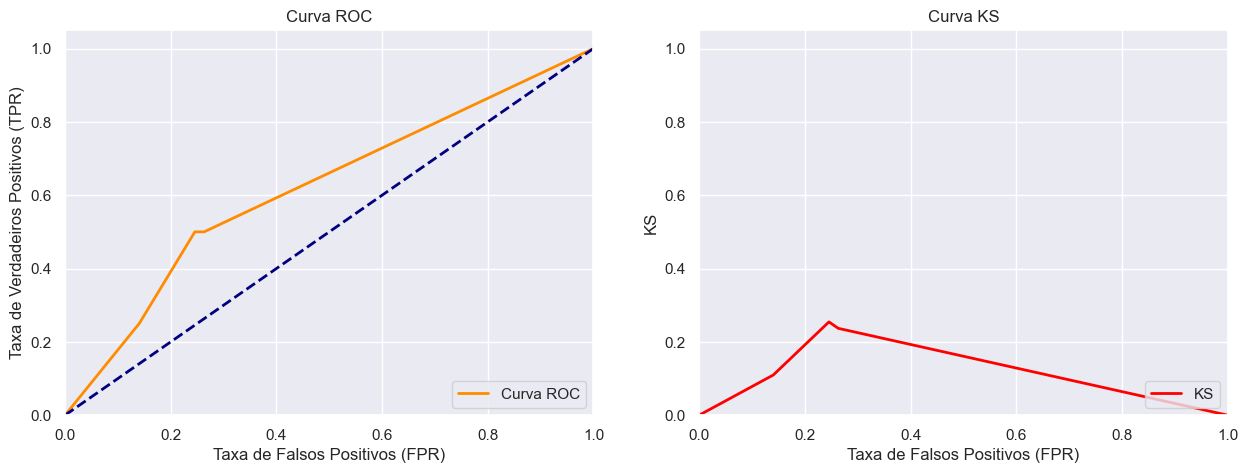

In [154]:
# Para verificar visualmente os gráficos, seguem os plots da Curva ROC e o gráfico KS
# Criando a base para plotar dois gráficos:
fig, (ax1, ax2)= plt.subplots(1, 2, figsize=(15,5))

# Primeiro gráfico: Curva ROC
ax1.plot(fpr, tpr, color='darkorange', lw=2, label='Curva ROC')
ax1.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
ax1.set_xlim([0.0, 1.0])
ax1.set_ylim([0.0, 1.05])
ax1.set_xlabel('Taxa de Falsos Positivos (FPR)')
ax1.set_ylabel('Taxa de Verdadeiros Positivos (TPR)')
ax1.set_title('Curva ROC')
ax1.legend(loc="lower right")

# Segundo gráfico: Gráfico do KS
ax2.plot(fpr, tpr - fpr, color= 'red', lw=2, label='KS')
ax2.set_xlim([0.0, 1.0])
ax2.set_ylim([0.0, 1.05])
ax2.set_xlabel('Taxa de Falsos Positivos (FPR)')
ax2.set_ylabel('KS')
ax2.set_title('Curva KS')
ax2.legend(loc="lower right")

plt.tight_layout
plt.show()

6. Tente melhorar o modelo obtido, por exemplo inserindo ou removendo variáveis.  
    Avalie as características do seu modelo (calibragem e acurácia).

In [232]:
# Selecionando as variáveis explicativas e a variável resposta
X_v1 = df[['sex', 'cp', 'trestbps', 'age', 'chol', 'fbs', 'restecg']]
y_v1 = df['num']  # 'num' é a variável resposta

# Dividindo o conjunto de dados em treinamento e teste
X_train_v1, X_test_v1, y_train_v1, y_test_v1 = train_test_split(X_v1, y_v1, test_size=0.2, random_state=42)

# Criando o modelo de regressão logística
logistic_model_v1 = LogisticRegression(max_iter=100000)  # Aumentamos o número de iterações para garantir a convergência

# Treinando o modelo com os dados de treinamento
logistic_model_v1.fit(X_train_v1, y_train_v1)

# Fazendo previsões com o modelo
y_pred_v1 = logistic_model_v1.predict(X_test_v1)

c:\Users\rafa_\anaconda3\Lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


<Figure size 800x600 with 0 Axes>

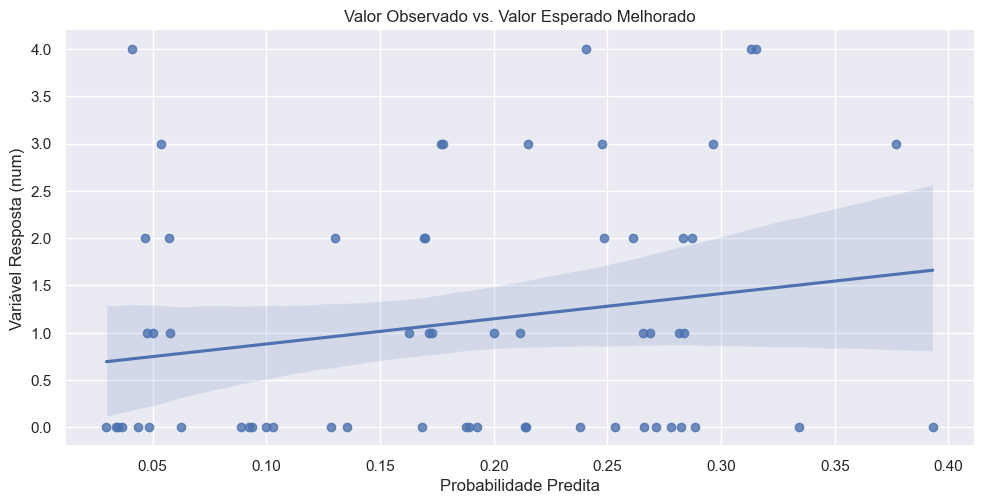

In [233]:
# Calculo da probabilidade de evento predita segundo o modelo para cada observação
probabilidades_preditas_v1 = logistic_model_v1.predict_proba(X_test_v1)[:, 1]

# Categorização das probabilidades em 5 grupos
categorias_probabilidade_v1 = pd.qcut(probabilidades_preditas_v1, q=5, labels=False)

# Calculo da probabilidade média e a taxa de eventos por grupo
df_resultados_v1 = pd.DataFrame({
    'Probabilidade Predita': probabilidades_preditas_v1,
    'Categoria de Probabilidade': categorias_probabilidade_v1,
    'Variável Resposta (num)': y_test_v1  # Variável de eventos
})

# Calcular a probabilidade média e a taxa de eventos por grupo
resultados_agrupados_v1 = df_resultados_v1.groupby('Categoria de Probabilidade').agg({
    'Probabilidade Predita': 'mean',
    'Variável Resposta (num)': 'mean'
}).reset_index()

resultados_agrupados_v1.columns = ['Categoria de Probabilidade', 'Probabilidade Média', 'Taxa de Eventos']

# Calculo da taxa de eventos observados por grupo
df_resultados_v1 = pd.DataFrame({
    'Probabilidade Predita': probabilidades_preditas_v1,
    'Variável Resposta (num)': y_test_v1  # Variável de eventos
})

# Calcular a taxa de eventos observados
taxa_eventos_obs_v1 = df_resultados_v1.groupby('Probabilidade Predita')['Variável Resposta (num)'].mean().reset_index()

# 3. Criar o gráfico comparando valor esperado versus valor observado usando lmplot
sns.set(style="darkgrid")
plt.figure(figsize=(8, 6))
sns.lmplot(data=taxa_eventos_obs_v1, x="Probabilidade Predita", y="Variável Resposta (num)", aspect=2)
plt.title('Valor Observado vs. Valor Esperado Melhorado')
plt.show()

In [234]:
# Calculando a acurácia
acuracia_v1 = accuracy_score(y_test_v1, y_pred_v1)

# Número de classes existentes
num_classes_v1 = len(np.unique(y_test_v1))

# Criando um array para armazenar as curvas ROC e as áreas sob a curva (AUC) para cada classe
roc_curves_v1 = []
auc_scores_v1 = []

for i in range(num_classes_v1):
    # Crie um vetor de classes binárias onde a classe atual seja 1 e as outras sejam 0
    y_true_class_v1 = np.where(y_test_v1 == i, 1, 0)
    y_pred_class_v1 = y_pred_v1  # Não é necessário indexar em y_pred

    # Calcule a curva ROC para a classe atual
    fpr_v1, tpr_v1, _ = roc_curve(y_true_class_v1, y_pred_class_v1)

    # Calcule a AUC para a classe atual
    auc_score_v1 = auc(fpr_v1, tpr_v1)

    roc_curves_v1.append((fpr_v1, tpr_v1))
    auc_scores_v1.append(auc_score_v1)

# Calcular o índice Gini
# Criando uma lista para armazenar os valores
gini_indices_v1 = []

# Calcule o índice Gini como a área entre a curva ROC e a linha diagonal
gini_index_v1 = 2 * auc_score_v1 - 1
gini_indices_v1.append(gini_index_v1)

# Calcular o KS
# Criando uma lista para armazenar os valores
ks_values_v1 = []

# Calculando o valor KS como a diferença máxima entre TPR e FPR
ks_value_v1 = max(tpr_v1 - fpr_v1)
ks_values_v1.append(ks_value_v1)

# Realizanbdo o print de todos os índices que foram calculados
print(f'Acurácia: {acuracia_v1:.2f}')

# Print para cada classe dos valores de Gini
print("\nIndice Gini:")
for i, gini_index_v1 in enumerate(gini_indices_v1):
    print(f"Classe {i}: {gini_index_v1:.2}")

# Print para cada classe dos valores de KS
print("\nIndice KS para classe:")
for i, ks_value_v1 in enumerate(ks_values_v1):
    print(f"Classe {i}: {ks_value_v1:.2}")

Acurácia: 0.48

Indice Gini:
Classe 0: 0.58

Indice KS para classe:
Classe 0: 0.59
